## 임포트

In [ ]:
import os
import time
import json
import random

import timm
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torchvision.models as tv_models
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
# from torchvision.datasets import ImageFolder
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split


## 파라미터

In [3]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# data config
data_path = '../data/'
train_path = '../data/train/'
test_path = '../data/test/'

# model config
model_name = 'resnet50' # 'resnet34' 'efficientnet-b0', ...

# training config
CFS = {'img_size': 224,
       'num_classes': 45,  # Adjust based on your dataset
       'LR': 1e-3,
       'EPOCHS': 20,
       'BATCH_SIZE': 64,
       'num_workers': 16
      }


cuda


## class dictionary

In [5]:
classes_to_idx = {
            '물류선하증권': 0,
            '주민생활지원': 1,
            '개인신용정보조회동의서(계약체결)': 2,
            '모집경위서': 3,
            '학자금대출신청서': 4,
            '금융증권신고서': 5,
            '개인신용정보조회동의서(상품소개)': 6,
            '농림.축산지원': 7,
            '회계.예산': 8,
            '금융은행위임장': 9,
            '금융증권위임장': 10,
            '금융은행신고서': 11,
            '물류포장명세서': 12,
            '지역문화': 13,
            '고객확인서(변경/정정)': 14,
            '금융보험합의서': 15,
            '금융증권확인서': 16,
            '물류기타': 17,
            '상수도관리': 18,
            '계약전알릴의무사항': 19,
            '상.하수도관리': 20,
            '사실조사확인서': 21,
            '금융보험위임장': 22,
            '금융보험청구서': 23,
            '금융보험동의서': 24,
            '금융보험확인서': 25,
            '주민복지': 26,
            '지역환경.산림': 27,
            '물류상업송장': 28,
            '보험차익 세제관련 안내확인서': 29,
            '물류원산지증명서': 30,
            '인.허가': 31,
            '산업진흥': 32,
            '금융증권신청서': 33,
            '청약서': 34,
            '주민자치': 35,
            '보험계약 변경신청 위임장': 36,
            '부동산대출신청서': 37,
            '일반행정': 38,
            '금융은행신청서': 39,
            '금융보험신청서': 40,
            '은행거래신청서(계좌개설)': 41,
            '정보보안동의서': 42,
            '도시개발': 43,
            '금융은행확인서': 44
        }


## seed

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42) # Seed 고정

## transfrom

In [7]:

train_transform = transforms.Compose([
    transforms.Resize((CFS['img_size'], CFS['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((CFS['img_size'], CFS['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## label 

In [8]:

def get_label(filename):
    """
    classification.py
    """
    # print(f"get_label: {filename}")
    with open(filename, 'r', encoding='utf-8') as file:
        data = json.load(file)

    if 'images' in data and len(data['images']) > 0:
        first_image = data['images'][0]
        if 'image.category' in first_image:
            image_category = first_image['image.category']
        elif 'document_name' in first_image:
            image_category = first_image['document_name']
    else:
        dic = {0: '은행', 1: '보험', 2: '증권', 3: '기타'}
        form_type = data['Images']['form_type']
        # print(f"form_type: {form_type}")
        if "form_industry" in data['Images']:
            industry = data['Images']['form_industry']
            image_category = "금융" + dic[industry] + data['Images']['form_type']
        else:
            image_category = "물류" + data['Images']['form_type']

    # print(image_category)  # 출력: 주민자치

    return image_category

## custom image Dataset

In [9]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, path, transform=None,):
        self.path = path
        self.transform = transform
        self.samples = []
        self.classes_to_idx = {
            '물류선하증권': 0,
            '주민생활지원': 1,
            '개인신용정보조회동의서(계약체결)': 2,
            '모집경위서': 3,
            '학자금대출신청서': 4,
            '금융증권신고서': 5,
            '개인신용정보조회동의서(상품소개)': 6,
            '농림.축산지원': 7,
            '회계.예산': 8,
            '금융은행위임장': 9,
            '금융증권위임장': 10,
            '금융은행신고서': 11,
            '물류포장명세서': 12,
            '지역문화': 13,
            '고객확인서(변경/정정)': 14,
            '금융보험합의서': 15,
            '금융증권확인서': 16,
            '물류기타': 17,
            '상수도관리': 18,
            '계약전알릴의무사항': 19,
            '상.하수도관리': 20,
            '사실조사확인서': 21,
            '금융보험위임장': 22,
            '금융보험청구서': 23,
            '금융보험동의서': 24,
            '금융보험확인서': 25,
            '주민복지': 26,
            '지역환경.산림': 27,
            '물류상업송장': 28,
            '보험차익 세제관련 안내확인서': 29,
            '물류원산지증명서': 30,
            '인.허가': 31,
            '산업진흥': 32,
            '금융증권신청서': 33,
            '청약서': 34,
            '주민자치': 35,
            '보험계약 변경신청 위임장': 36,
            '부동산대출신청서': 37,
            '일반행정': 38,
            '금융은행신청서': 39,
            '금융보험신청서': 40,
            '은행거래신청서(계좌개설)': 41,
            '정보보안동의서': 42,
            '도시개발': 43,
            '금융은행확인서': 44
        }

        label_set = set()
        for folder in os.listdir(self.path):
            folder_path = os.path.join(self.path, folder)
            if not os.path.isdir(folder_path):
                continue
            for f in os.listdir(folder_path):
                if f.lower().endswith(('.jpg', '.png')):
                    img_path = os.path.join(folder_path, f)
                    json_path = img_path.rsplit('.', 1)[0] + '.json'
                    label = get_label(json_path) # 라벨을 가져옵니다
                    self.samples.append((img_path, self.classes_to_idx[label]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        label = torch.tensor(label)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label
            

## Dataloader

In [10]:
# 전체 데이터셋 로드
full_dataset = ImageDataset(train_path, transform=None)
print(f"원본 데이터셋 크기: {len(full_dataset)}")

targets = [label for _, label in full_dataset.samples]
print(f"클래스 수: {len(set(targets))}")
print(f"클래스 이름: {set(targets)}")

# Stratified Split
train_idx, val_idx = train_test_split(
    range(len(targets)), test_size=0.2, stratify=targets, random_state=42
)

# Subset + transform 각각 적용
train_dataset = Subset(ImageDataset(train_path, transform=train_transform), train_idx)
val_dataset = Subset(ImageDataset(train_path, transform=test_transform), val_idx)
print(f'train 이미지 수: {len(train_dataset)}, valid 이미지 수: {len(val_dataset)}')

# DataLoader 정의
train_loader = DataLoader(
    train_dataset,
    batch_size=CFS['BATCH_SIZE'],
    shuffle=True,
    num_workers=CFS['num_workers'],
    pin_memory=True,
    drop_last=False
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CFS['BATCH_SIZE'],
    shuffle=False,
    num_workers=int(CFS['num_workers'] / 2),
    pin_memory=True
)


원본 데이터셋 크기: 8662
클래스 수: 45
클래스 이름: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44}
train 이미지 수: 6929, valid 이미지 수: 1733


## Model

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, num_classes):
        super(BaseModel, self).__init__()
        self.backbone = tv_models.resnet50(weights=tv_models.ResNet50_Weights.DEFAULT)  # ResNet50 모델 불러오기
        self.feature_dim = self.backbone.fc.in_features 
        self.backbone.fc = nn.Identity()  # feature extractor로만 사용
        self.head = nn.Linear(self.feature_dim, num_classes)  # 분류기 for classification

    def forward(self, x):
        x = self.backbone(x)       
        x = self.head(x) 
        return x

model = BaseModel(CFS['num_classes']).to(device)
print(model)

BaseModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

## Train

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=CFS['LR'])

train_losses = []
val_losses = []

for epoch in range(CFS['EPOCHS']):
    model.train()
    train_loss = 0.0
    preds_list = []
    targets_list = []

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{CFS['EPOCHS']}"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation {epoch+1}/{CFS['EPOCHS']}"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item() * images.size(0)

            preds = outputs.argmax(dim=1)
            preds_list.extend(preds.detach().cpu().numpy())
            targets_list.extend(labels.detach().cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_losses.append(val_loss)

    val_acc = correct / total *100
    f1 = f1_score(targets_list, preds_list, average='macro')
    # 결과 출력
    print(f"Epoch {epoch+1} | "
			f"Train Loss: {train_loss:.4f} | "
			f"Val Loss: {val_loss:.4f} | "
			f"Valid Accuracy : {val_acc:.4f} | "
			f"Correct: {correct}/1733 | "
			f"F1 Score: {f1:.4f}%")

Validation 1/20: 100%|██████████| 28/28 [00:22<00:00,  1.22it/s]


Epoch 1 | Train Loss: 10459.9255 | Val Loss: 2156.1850 | Valid Accuracy : 60.0692 | Correct: 1041/1733 | F1 Score: 0.4617%


Validation 2/20: 100%|██████████| 28/28 [00:23<00:00,  1.20it/s]


Epoch 2 | Train Loss: 7266.9907 | Val Loss: 2060.3056 | Valid Accuracy : 62.3774 | Correct: 1081/1733 | F1 Score: 0.5256%


Validation 3/20: 100%|██████████| 28/28 [00:22<00:00,  1.26it/s]


Epoch 3 | Train Loss: 6152.3102 | Val Loss: 2073.2042 | Valid Accuracy : 62.8390 | Correct: 1089/1733 | F1 Score: 0.5771%


Validation 4/20: 100%|██████████| 28/28 [00:22<00:00,  1.26it/s]


Epoch 4 | Train Loss: 5073.1860 | Val Loss: 1921.4262 | Valid Accuracy : 65.4934 | Correct: 1135/1733 | F1 Score: 0.5895%


Validation 5/20: 100%|██████████| 28/28 [00:23<00:00,  1.19it/s]


Epoch 5 | Train Loss: 3974.7639 | Val Loss: 2265.9298 | Valid Accuracy : 61.9158 | Correct: 1073/1733 | F1 Score: 0.3985%


Validation 6/20: 100%|██████████| 28/28 [00:22<00:00,  1.27it/s]


Epoch 6 | Train Loss: 2985.3019 | Val Loss: 2084.9575 | Valid Accuracy : 66.1858 | Correct: 1147/1733 | F1 Score: 0.7084%


Validation 7/20: 100%|██████████| 28/28 [00:22<00:00,  1.24it/s]


Epoch 7 | Train Loss: 2151.4635 | Val Loss: 2479.2366 | Valid Accuracy : 68.2631 | Correct: 1183/1733 | F1 Score: 0.7177%


Validation 8/20: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 8 | Train Loss: 1669.7525 | Val Loss: 2289.4584 | Valid Accuracy : 67.8015 | Correct: 1175/1733 | F1 Score: 0.7312%


Validation 9/20: 100%|██████████| 28/28 [00:22<00:00,  1.27it/s]


Epoch 9 | Train Loss: 979.9125 | Val Loss: 2456.4283 | Valid Accuracy : 65.9550 | Correct: 1143/1733 | F1 Score: 0.7849%


Validation 10/20: 100%|██████████| 28/28 [00:22<00:00,  1.23it/s]


Epoch 10 | Train Loss: 608.3400 | Val Loss: 2629.4957 | Valid Accuracy : 69.5326 | Correct: 1205/1733 | F1 Score: 0.7629%


Validation 11/20: 100%|██████████| 28/28 [00:25<00:00,  1.12it/s]


Epoch 11 | Train Loss: 735.3476 | Val Loss: 2635.3864 | Valid Accuracy : 68.8979 | Correct: 1194/1733 | F1 Score: 0.7835%


Validation 12/20: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 12 | Train Loss: 596.0169 | Val Loss: 2687.9278 | Valid Accuracy : 70.2250 | Correct: 1217/1733 | F1 Score: 0.7560%


Validation 13/20: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 13 | Train Loss: 472.4473 | Val Loss: 2672.1675 | Valid Accuracy : 71.7830 | Correct: 1244/1733 | F1 Score: 0.7543%


Validation 14/20: 100%|██████████| 28/28 [00:22<00:00,  1.24it/s]


Epoch 14 | Train Loss: 563.6707 | Val Loss: 2496.9865 | Valid Accuracy : 70.4559 | Correct: 1221/1733 | F1 Score: 0.7714%


Validation 15/20: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 15 | Train Loss: 405.2559 | Val Loss: 2766.2378 | Valid Accuracy : 70.1673 | Correct: 1216/1733 | F1 Score: 0.7630%


Validation 16/20: 100%|██████████| 28/28 [00:23<00:00,  1.19it/s]


Epoch 16 | Train Loss: 153.8044 | Val Loss: 2582.0529 | Valid Accuracy : 73.0525 | Correct: 1266/1733 | F1 Score: 0.7903%


Validation 17/20: 100%|██████████| 28/28 [00:22<00:00,  1.27it/s]


Epoch 17 | Train Loss: 57.1068 | Val Loss: 2640.9610 | Valid Accuracy : 72.9948 | Correct: 1265/1733 | F1 Score: 0.7906%


Validation 18/20: 100%|██████████| 28/28 [00:21<00:00,  1.28it/s]


Epoch 18 | Train Loss: 25.3403 | Val Loss: 2695.7506 | Valid Accuracy : 74.3797 | Correct: 1289/1733 | F1 Score: 0.7937%


Validation 19/20: 100%|██████████| 28/28 [00:22<00:00,  1.24it/s]


Epoch 19 | Train Loss: 13.2847 | Val Loss: 2917.8947 | Valid Accuracy : 74.9567 | Correct: 1299/1733 | F1 Score: 0.7832%


Validation 20/20: 100%|██████████| 28/28 [00:22<00:00,  1.22it/s]

Epoch 20 | Train Loss: 10.3932 | Val Loss: 2888.7844 | Valid Accuracy : 75.3029 | Correct: 1305/1733 | F1 Score: 0.7839%


## Training plot

In [15]:
val_losses

[2156.1850118637085,
 2060.3055812120438,
 2073.2042323350906,
 1921.4261521100998,
 2265.9297852516174,
 2084.957463502884,
 2479.23659157753,
 2289.458372116089,
 2456.428326368332,
 2629.4957473278046,
 2635.386373400688,
 2687.9278115034103,
 2672.167493581772,
 2496.986453294754,
 2766.2378420829773,
 2582.052932739258,
 2640.9610476493835,
 2695.7505831718445,
 2917.8947372436523,
 2888.784429550171]

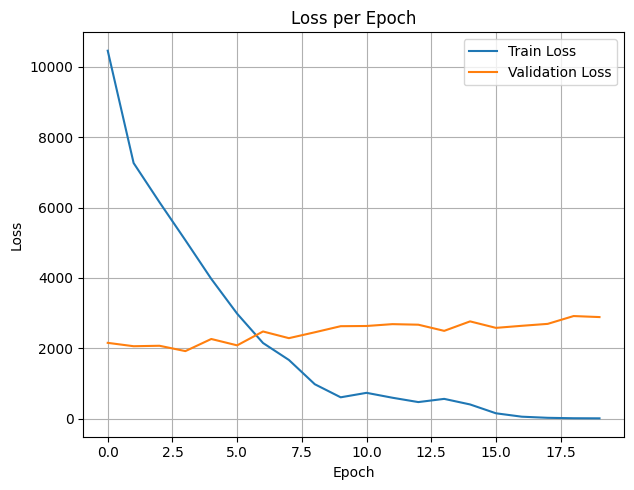

In [13]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses,):

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss per Epoch')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(train_losses, val_losses)

## inference

In [ ]:
# Test dataset
test_dataset = ImageDataset(test_path, transform=test_transform)
# Test DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=CFS['BATCH_SIZE'],
    shuffle=False,
    num_workers=int(CFS['num_workers'] / 2),
    pin_memory=True
)
# Inference
model.eval()
preds_list = []
labels_list = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Inference"):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        preds_list.extend(preds.detach().cpu().numpy())
        labels_list.extend(labels.detach().cpu().numpy())


        correct += (preds == labels).sum().item()
        total += labels.size(0)

    val_acc = correct / total *100
    f1 = f1_score(labels_list, preds_list, average='macro')

# 결과 출력
print(f"Test Accuracy: {val_acc:.4f}%")
print(f"Test F1 Score: {f1:.4f}%")



Inference: 100%|██████████| 34/34 [00:26<00:00,  1.28it/s]

Test Accuracy: 74.8013%
Test F1 Score: 0.7913%
